In [18]:
import fonctions as f
dataSerie = f.pd.read_csv("dataMod.csv", index_col =["DATE"] , parse_dates = ["DATE"])

In [19]:
from datetime import datetime


df = f.pd.read_csv("data.csv", index_col=0)
start_date = f.pd.to_datetime("2024-08-05")
df["DATE"]=df['DATE'].apply(lambda x: f.pd.to_datetime(str(int(x)), format='%Y%m%d'))
filtered_df = df[df['DATE'] >= start_date]

print(filtered_df)

              DATE   RR  DRR    TN     HTN    TX     HTX    TM   TMNX  TNSOL  \
POSTE                                                                          
1014002 2024-08-05  NaN  NaN   NaN     NaN   NaN     NaN   NaN    NaN    NaN   
1014002 2024-08-06  NaN  NaN   NaN     NaN   NaN     NaN   NaN    NaN    NaN   
1014002 2024-08-07  NaN  NaN   NaN     NaN  30,6  1509.0   NaN    NaN    NaN   
1014002 2024-08-08  0,0  NaN  16,2  2335.0  29,9  1229.0  21,8  23,05    NaN   
1014002 2024-08-09  0,0  NaN   9,9   446.0  32,2  1321.0  21,3  21,05    NaN   
...            ...  ...  ...   ...     ...   ...     ...   ...    ...    ...   
1014002 2024-10-27  0,2  NaN   5,7   633.0  21,9  1354.0  13,3  13,80    NaN   
1014002 2024-10-28  0,2  NaN   6,7   546.0  21,9  1236.0  12,6  14,30    NaN   
1014002 2024-10-29  0,4  NaN   6,4  2251.0  21,7  1236.0  12,0  14,05    NaN   
1014002 2024-10-30  0,2  NaN   4,9   632.0  21,8  1253.0  11,0  13,35    NaN   
1014002 2024-10-31  0,0  NaN   2,9   657

(array([18993., 19113., 19236., 19358., 19478., 19601., 19723., 19844.,
        19967.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09')])

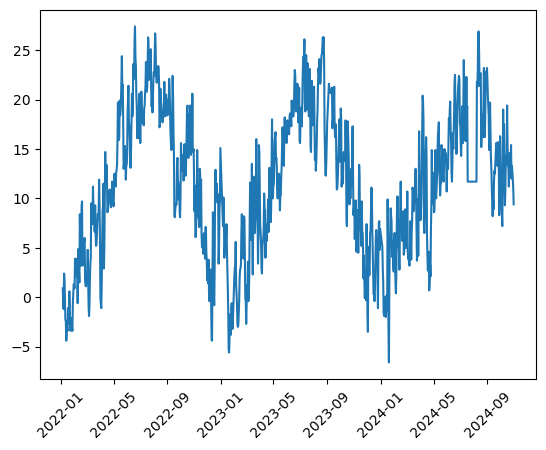

In [25]:
#Visualtion de la série
f.plt.plot(dataSerie.index, dataSerie['TM'])
f.plt.xticks(rotation=45)

# Vérification de la stationnarité
Vérifier la stationnarité est une étape cruciale dans l'analyse des séries temporelles, car de nombreux modèles statistiques et de machine learning (comme ARIMA, SARIMA ou même certains modèles de régression) supposent que les données sont stationnaires pour produire des résultats fiables. 
Le test de Dickey-Fuller : il s'agit de l'un des tests statistiques permettant de vérifier la stationnarité. Ici, l'hypothèse nulle est que la série TS n'est pas stationnaire. Les résultats du test comprennent une statistique de test et des  valeurs critiques pour les niveaux de confiance des différences. Si la « statistique de test » est inférieure à la « valeur critique », nous pouvons rejeter l'hypothèse nulle et dire que la série est stationnaire.

In [22]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = f.pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [23]:
#On teste la stationnarité du modèle

test_stationarity(dataSerie["TM"])

Results of Dickey-Fuller Test:
Test Statistic                   -3.525958
p-value                           0.007345
#Lags Used                        6.000000
Number of Observations Used    1015.000000
Critical Value (1%)              -3.436809
Critical Value (5%)              -2.864392
Critical Value (10%)             -2.568288
dtype: float64


La statistique du test de Dickey-Fuller est inférieure à la valeur critique de 1% , donc cette série est stationnaire avec une confiance de 99%

In [ ]:
#On divise la base en une partie test et une partie apprentissage
train_size = int(len(dataSerie) * 0.8)
train, test = dataSerie[:train_size], dataSerie[train_size:]

In [29]:
#moving_avg = train["TM"].rolling(window=12).mean()
#f.plt.plot(train["TM"])
#f.plt.plot(moving_avg, color='red')
#moving_avg.head(12)

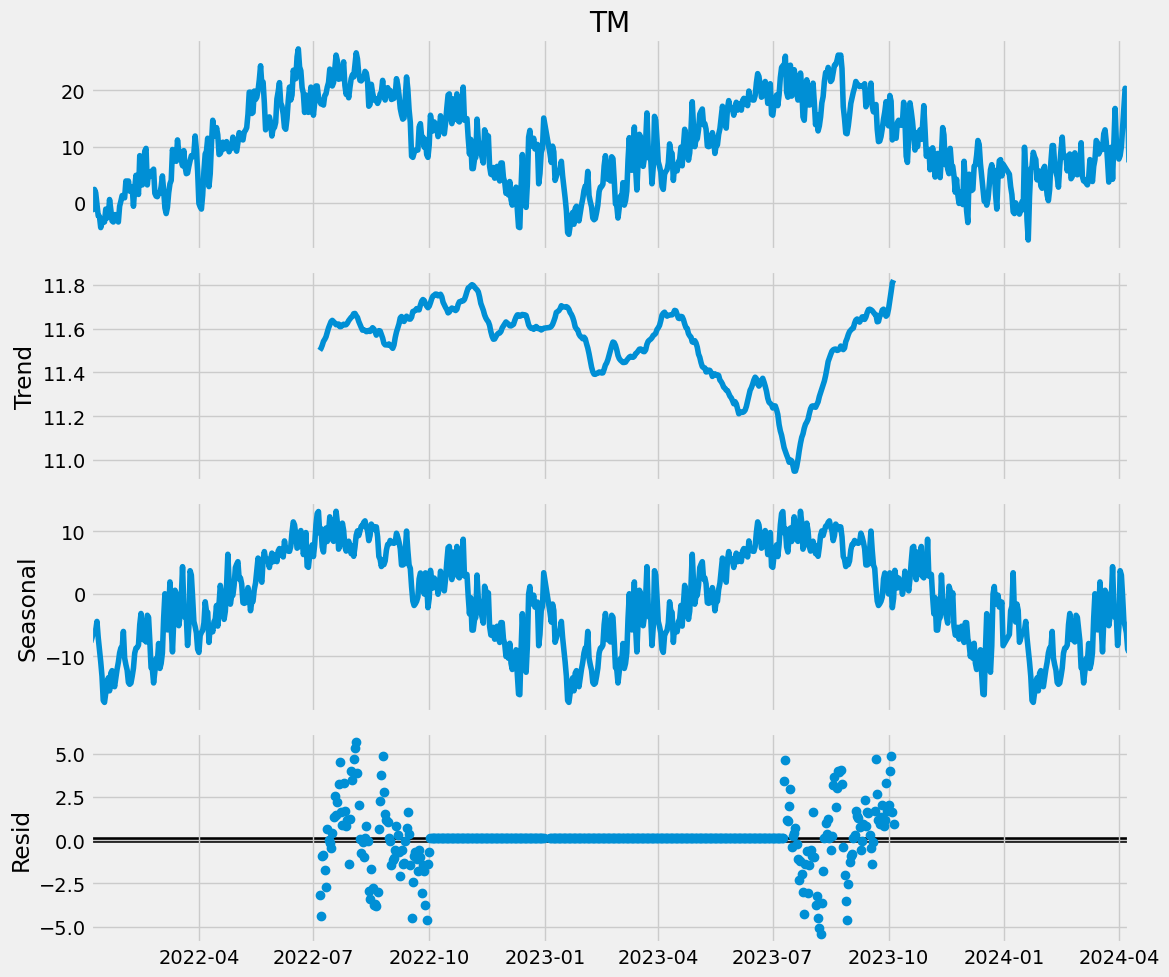

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 12, 10
f.plt.style.use('fivethirtyeight')
températures = train["TM"]

# period est le nombre de points de données dans un cycle répété.
result = seasonal_decompose(températures, model='additive', period=365)
result.plot()
plt.show()

La statistique du test de Dickey-Fuller est significativement inférieure à la valeur critique de 1 % . Cette série est donc très proche de la stationnarité

# ACF et PACF test
Nombre de termes AR (autorégressifs) (p) : les termes AR ne sont que des décalages de la variable dépendante. Par exemple, si p est 5, les prédicteurs pour x(t) seront x(t-1)….x(t-5).
Nombre de termes MA (moyenne mobile) (q) : les termes MA sont des erreurs de prévision décalées dans l'équation de prédiction. Par exemple, si q est 5, les prédicteurs pour x(t) seront e(t-1)….e(t-5) où e(i) est la différence entre la moyenne mobile au i ème instant et la valeur réelle.
Nombre de différences (d) : il s'agit du nombre de différences non saisonnières, c'est-à-dire que dans ce cas, nous avons pris la différence de premier ordre. Nous pouvons donc soit passer cette variable et mettre d=0, soit passer la variable d'origine et mettre d=1. Les deux généreront les mêmes résultats.
Une question importante ici est de savoir comment déterminer la valeur de « p » et « q ». Nous utilisons deux tracés pour déterminer ces nombres. Commençons par les examiner.

Fonction d'autocorrélation (ACF) : Il s'agit d'une mesure de la corrélation entre le TS et une version retardée de lui-même. Par exemple, à un décalage de 5, l'ACF comparerait la série à l'instant 't1'…'t2' avec la série à l'instant 't1-5'…'t2-5' (t1-5 et t2 étant les points finaux).
Fonction d'autocorrélation partielle (PACF) : elle mesure la corrélation entre le TS et une version décalée de lui-même, mais après avoir éliminé les variations déjà expliquées par les comparaisons intermédiaires. Par exemple, au décalage de 5, elle vérifiera la corrélation mais supprimera les effets déjà expliqués par les décalages de 1 à 4.


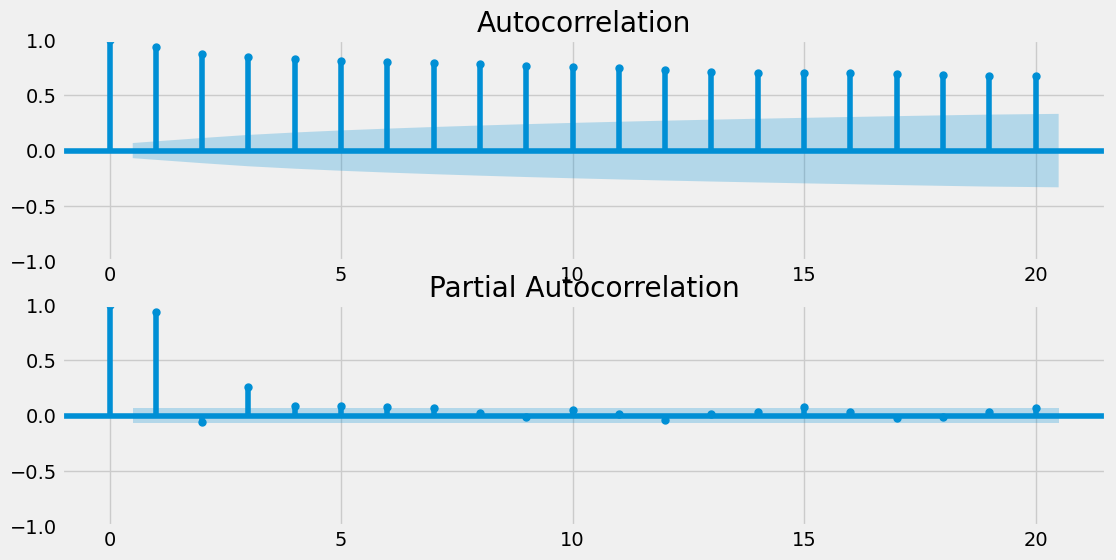

In [32]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(train["TM"], ax=ax[0], lags=20)
ax[1] = plot_pacf(train["TM"], ax=ax[1], lags=20)

Le Graphique ACF montre que une autocorrélation qui décroit lentement cela peut indiquer la présence de saisonnalité étant donné que notre série est staionnaire.
Nous utiliserons le modèle SARIMA pour représenter notre série